In [1]:
# 让 Notebook 自动重载本地模块改动（避免手动重启内核）
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

from tplc_algo.data import load_team_merged_dataframe
from tplc_algo.models import TPLCNet
from tplc_algo.pipeline import make_loaders, prepare_greenhouse_datasets
from tplc_algo.train import Trainer, TrainConfig
from tplc_algo.utils import seed_everything

# ======= results / tuner_logs 相关（参考 danshen_GSDAE 结构） =======
from tplc_algo.exp_utils import (
    create_run_dir,
    save_config_json,
    save_env_json,
    save_history_csv,
    save_metrics_json,
    save_figure,
    save_text,
 )
from tplc_algo.tuner import random_search

In [2]:
# ========= 1) 配置 =========
seed_everything(42)

# ========= 数据集选择 =========
# 选项1: 温室挑战赛数据集（多表数据）
# 选项2: 单文件温室数据集
dataset_type = 'single_file'  # 'challenge' 或 'single_file'

if dataset_type == 'challenge':
    # 温室挑战赛数据集
    dataset_root = (Path('..') / 'datasets' / '自主温室挑战赛').resolve()
    team = 'AICU'  # 可改：Reference / IUACAAS / TheAutomators ...
    team_dir = dataset_root / team
    use_single_file = False
elif dataset_type == 'single_file':
    # 单文件温室数据集
    # 注意：dataset_root 是文件所在目录，team 设为 '.' 以便路径拼接正确
    dataset_root = Path(r'D:\学位会\数据集\温室环境数据(4万条)')
    single_file_path = dataset_root / 'GreenhouseClimate1.csv'
    team = '.'  # 使用当前目录，避免额外的子目录
    use_single_file = True
    print('使用单文件数据集:', single_file_path)
else:
    raise ValueError(f"未知的 dataset_type: {dataset_type}")

seq_len = 96   # 约 1 天（5min 频率）
pred_len = 24   # 约 6 小时
stride = 1

num_scales = 2
top_k_periods = 3
hidden_dim = 64

batch_size = 32
epochs = 20
lr = 1e-3
weight_decay = 0.0  # AdamW 的 L2 正则强度（调参会覆盖）

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ========= 训练稳定性推荐配置（CUDA 上收益明显） =========
use_amp = (device == 'cuda')
grad_clip_max_norm = 1.0
lr_scheduler = 'plateau'
plateau_patience = 3
plateau_factor = 0.5
early_stop_patience = 6
early_stop_min_delta = 0.0
min_lr = 0.0

# ========= 调参建议（trial epochs 建议 5-10） =========
tune_epochs = 8

# ========= results：每次运行自动创建时间戳目录 =========
exp_name = f"tplcnet_greenhouse_{team}_{dataset_type}"
run_dir = create_run_dir(exp_name)
ckpt_path = run_dir / 'checkpoints' / 'tplcnet_best.pt'
print('device =', device)
if not use_single_file:
    print('team_dir =', team_dir)
print('run_dir =', run_dir)

使用单文件数据集: D:\学位会\数据集\温室环境数据(4万条)\GreenhouseClimate1.csv
device = cuda
run_dir = D:\degree_code\scheme_1\TPLC_Net\results\tplcnet_greenhouse_._single_file_20260115_164532


In [3]:
# ========= 2) 读取数据 =========
if use_single_file:
    # 单文件数据集
    import pandas as pd
    merged_df = pd.read_csv(single_file_path)
    print('单文件数据集 shape:', merged_df.shape)
    print('columns:', list(merged_df.columns)[:20], '...')
else:
    # 多表数据集
    merged_df = load_team_merged_dataframe(team_dir)
    print('merged_df shape:', merged_df.shape)
    print('columns:', list(merged_df.columns)[:20], '...')
merged_df.head()

单文件数据集 shape: (47809, 50)
columns: ['time', 'AssimLight', 'BlackScr', 'CO2air', 'Cum_irr', 'EC_drain_PC', 'EnScr', 'HumDef', 'PipeGrow', 'PipeLow', 'Rhair', 'Tair', 'Tot_PAR', 'Tot_PAR_Lamps', 'VentLee', 'Ventwind', 'assim_sp', 'assim_vip', 'co2_dos', 'co2_sp'] ...


,time,AssimLight,BlackScr,CO2air,Cum_irr,EC_drain_PC,EnScr,HumDef,PipeGrow,PipeLow,...,t_rail_min_sp,t_rail_min_vip,t_vent_sp,t_ventlee_vip,t_ventwind_vip,water_sup,water_sup_intervals_sp_min,water_sup_intervals_vip_min,window_pos_lee_sp,window_pos_lee_vip
0,43815.00000,0.0,35.000000,439.0,0.48,3.61,96.0,6.96,0.0,50.9,...,NaN,0.0,NaN,25.0,26.0,4.0,NaN,1000.0,NaN,1.2
1,43815.00347,0.0,85.000001,459.0,0.72,3.61,96.0,7.45,0.0,49.3,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2
2,43815.00694,0.0,95.999999,461.0,0.72,3.61,94.6,5.99,0.0,47.6,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2
3,43815.01042,0.0,92.000000,465.0,0.72,3.61,94.6,6.57,0.0,46.1,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2
4,43815.01389,0.0,92.000000,467.0,0.72,3.62,95.3,6.99,0.0,45.2,...,NaN,0.0,NaN,25.0,26.0,6.0,NaN,1000.0,NaN,1.2


In [4]:
# ========= 3) 数据准备（统一走 pipeline：特征筛选 + 标准化 + DataLoader） =========
# 根据数据集类型选择特征
if dataset_type == 'challenge':
    # 温室挑战赛数据集 - 10个核心特征
    selected_features = ['Tair', 'Rhair', 'CO2air', 'Tot_PAR', 'PipeGrow', 
                        'VentLee', 'Ventwind', 'HumDef', 'water_sup', 'EnScr']
    print('使用温室挑战赛数据集的10个核心特征')
elif dataset_type == 'single_file':
    # 单文件数据集 - 使用相同的10个核心特征（结构相同）
    selected_features = ['Tair', 'Rhair', 'CO2air', 'Tot_PAR', 'PipeGrow', 
                        'VentLee', 'Ventwind', 'HumDef', 'water_sup', 'EnScr']
    print('使用单文件数据集的10个核心特征')
else:
    selected_features = None
    print('使用所有可用特征')

# 推荐的10个核心特征说明（对温室植物生长影响最大）：
# 1. Tair - 空气温度（最关键）
# 2. Rhair - 空气相对湿度（水分管理）
# 3. CO2air - CO2浓度（光合作用）
# 4. Tot_PAR - 光合有效辐射（光照）
# 5. PipeGrow - 生长管加热（温度控制）
# 6. VentLee - 背风侧通风（通风管理）
# 7. Ventwind - 迎风侧通风（通风管理）
# 8. HumDef - 湿度缺失（蒸腾作用指标）
# 9. water_sup - 灌溉供水量（水分供应）
# 10. EnScr - 节能幕（能量管理）

if use_single_file:
    # 单文件数据集需要特殊处理
    prepared = prepare_greenhouse_datasets(
        dataset_root=dataset_root,
        team=team,
        seq_len=seq_len,
        pred_len=pred_len,
        stride=stride,
        base_table='GreenhouseClimate1.csv',  # 指定单文件
        extra_tables=(),  # 不加载额外表
        selected_features=selected_features,
        missing_rate_threshold=0.7,
        drop_constant=True,
        protect_target_cols=True,
    )
else:
    # 多表数据集（温室挑战赛）
    prepared = prepare_greenhouse_datasets(
        dataset_root=dataset_root,
        team=team,
        seq_len=seq_len,
        pred_len=pred_len,
        stride=stride,
        selected_features=selected_features,
        missing_rate_threshold=0.7,
        drop_constant=True,
        protect_target_cols=True,
    )

feature_cols = prepared.feature_cols
target_cols = prepared.target_cols
target_scaler = prepared.target_scaler

train_loader, val_loader, test_loader = make_loaders(prepared, batch_size=batch_size)

print('input_dim =', len(feature_cols))
print('target_dim =', len(target_cols), target_cols)
print('train batches:', len(train_loader))

使用单文件数据集的10个核心特征
使用 selected_features: 10 个特征
input_dim = 10
target_dim = 3 ['Tair', 'Rhair', 'CO2air']
train batches: 1042


In [5]:
# ========= 6.5) 自动调参（可选） =========
# 兜底：如果你只运行了本单元而没跑“1) 配置”，这里给默认值避免 NameError
if 'weight_decay' not in globals():
    weight_decay = 0.0
if 'tune_epochs' not in globals():
    tune_epochs = 8

enable_tuning = True  # True 启用随机搜索；False 跳过，直接用上面的默认/手动设置超参
max_trials = 15       # 调参次数（建议先小一点）

best_params = {}
tuner_run_dir = None
if enable_tuning:
    # 搜索空间（可按需要扩展/收缩）
    search_space = {
        # 模型超参
        'hidden_dim': [32, 64, 96],
        'top_k_periods': [2, 3, 4],
        'num_scales': [1, 2, 3],
        # 训练超参
        'lr': (5e-4, 3e-3, 'float'),
        'weight_decay': (0.0, 1e-3, 'float'),
    }

    def build_model_fn(params: dict):
        return TPLCNet(
            input_dim=len(feature_cols),
            target_dim=len(target_cols),
            seq_len=seq_len,
            pred_len=pred_len,
            num_scales=int(params.get('num_scales', num_scales)),
            top_k_periods=int(params.get('top_k_periods', top_k_periods)),
            hidden_dim=int(params.get('hidden_dim', hidden_dim)),
        )

    # 注意：调参日志会写到 TPLC_Net/tuner_logs/ 下
    best_params, trial_results, tuner_run_dir = random_search(
        build_model_fn=build_model_fn,
        train_loader=train_loader,
        val_loader=val_loader,
        search_space=search_space,
        max_trials=max_trials,
        base_seed=42,
        exp_name='tplcnet_greenhouse',
        device=device,
        fixed_train_cfg={'epochs': tune_epochs},  # 调参阶段建议 5-10 个 epoch（更稳定）
    )

    print('best_params =', best_params)
    print('tuner_run_dir =', tuner_run_dir)

    # 用最佳超参覆盖后续正式训练配置（非常关键：确保“调参结果真的用上”）
    hidden_dim = int(best_params.get('hidden_dim', hidden_dim))
    top_k_periods = int(best_params.get('top_k_periods', top_k_periods))
    num_scales = int(best_params.get('num_scales', num_scales))
    lr = float(best_params.get('lr', lr))
    weight_decay = float(best_params.get('weight_decay', weight_decay))

    # 调参内部会改变随机种子；这里重置一下，避免正式训练受最后一个 trial 影响
    seed_everything(42)

e:\anaconda\envs\TPLC_Net\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tuning (trial): 100%|##########| 15/15 [32:53<00:00, 131.56s/trial, best=0.6979, last=0.9029]

best_params = {'hidden_dim': 32, 'top_k_periods': 4, 'num_scales': 1, 'lr': 0.0021917487185572782, 'weight_decay': 0.0008921795677048455}
tuner_run_dir = D:\degree_code\scheme_1\TPLC_Net\tuner_logs\tplcnet_greenhouse_20260115_164533


In [6]:
# ========= 7) 构建模型并训练 =========
model = TPLCNet(
    input_dim=len(feature_cols),
    target_dim=len(target_cols),
    seq_len=seq_len,
    pred_len=pred_len,
    num_scales=num_scales,
    top_k_periods=top_k_periods,
    hidden_dim=hidden_dim,
 )

trainer = Trainer(
    model=model,
    cfg=TrainConfig(
        epochs=epochs,
        lr=lr,
        weight_decay=weight_decay,
        device=device,
        ckpt_path=ckpt_path,

        # 稳定性增强
        use_amp=use_amp,
        grad_clip_max_norm=grad_clip_max_norm,
        lr_scheduler=lr_scheduler,
        plateau_patience=plateau_patience,
        plateau_factor=plateau_factor,
        early_stop_patience=early_stop_patience,
        early_stop_min_delta=early_stop_min_delta,
        min_lr=min_lr,

        show_progress=True,
        progress_granularity='batch',
    )
 )
history = trainer.fit(train_loader, val_loader=val_loader)

# ===== 保存本次运行配置/环境/训练曲线 =====
config_payload = {
    'team': team,
    'dataset_root': str(dataset_root),
    'seq_len': seq_len,
    'pred_len': pred_len,
    'stride': stride,
    'feature_cols': feature_cols,
    'target_cols': target_cols,
    'model': {
        'num_scales': num_scales,
        'top_k_periods': top_k_periods,
        'hidden_dim': hidden_dim,
    },
    'train': {
        'batch_size': batch_size,
        'epochs': epochs,
        'lr': lr,
        'weight_decay': weight_decay,
        'device': device,
        'use_amp': use_amp,
        'grad_clip_max_norm': grad_clip_max_norm,
        'lr_scheduler': lr_scheduler,
        'plateau_patience': plateau_patience,
        'plateau_factor': plateau_factor,
        'early_stop_patience': early_stop_patience,
        'early_stop_min_delta': early_stop_min_delta,
        'min_lr': min_lr,
    },
    'tuning': {
        'enabled': enable_tuning,
        'best_params': best_params,
        'tuner_run_dir': str(tuner_run_dir) if tuner_run_dir is not None else None,
        'trial_epochs': tune_epochs if 'tune_epochs' in globals() else None,
    },
}
save_config_json(run_dir, config_payload)
save_env_json(run_dir)
save_history_csv(run_dir, history)

# 额外：把 checkpoint 路径也记一份文本
save_text(run_dir / 'artifacts' / 'checkpoint_path.txt', str(ckpt_path))

# ===== [新增] 保存 best_params.json 到当前目录供对比实验使用 =====
if enable_tuning and best_params:
    import json
    # path: scheme_1/TPLC_Net/best_params.json
    # 假设当前 notebook 就在 TPLC_Net 目录下 (即当前工作目录)
    best_params_path = Path('best_params.json').resolve()
    print(f"📡 正在保存最佳超参到公共配置文件: {best_params_path}")
    try:
        with open(best_params_path, 'w', encoding='utf-8') as f:
            json.dump(best_params, f, indent=4)
        print("✅ best_params.json 已更新，其他实验脚本(如 run_compare_experiment.ipynb) 将自动加载此配置。")
    except Exception as e:
        print(f"❌ 保存 best_params.json 失败: {e}")

print('saved to:', run_dir)
history

train (epoch):  80%|########  | 16/20 [05:15<01:18, 19.71s/epoch, train=0.1452, val=0.9044, stop=best@11]

📡 正在保存最佳超参到公共配置文件: D:\degree_code\scheme_1\TPLC_Net\best_params.json
✅ best_params.json 已更新，其他实验脚本(如 run_compare_experiment.ipynb) 将自动加载此配置。
saved to: D:\degree_code\scheme_1\TPLC_Net\results\tplcnet_greenhouse_._single_file_20260115_164532


{'train_loss': [0.24994352649389667,
  0.16798261067545803,
  0.15976675095719475,
  0.15623062221966183,
  0.15433809606647994,
  0.15272825412924138,
  0.1510877621265382,
  0.15042894510927676,
  0.149898392854405,
  0.14976714647262432,
  0.14953274565128585,
  0.14876739040817957,
  0.1482685673874651,
  0.1481301555635261,
  0.14775256644541152,
  0.14544765108520605,
  0.14516763187472972],
 'val_loss': [1.0430462398873817,
  0.9376990702167086,
  0.942251323183011,
  0.8304132793471937,
  0.893749972917675,
  0.8652562094563401,
  0.8039743717687117,
  0.8413146988973677,
  0.8272533268663561,
  0.8014550978624368,
  0.777485707681646,
  0.8664475385402564,
  0.9100965904565462,
  0.8714066192306333,
  0.8474171433267714,
  0.8319708960451708,
  0.9043720268277339],
 'val_mae': [0.8083146159369095,
  0.7691847294396378,
  0.7696371123632681,
  0.723703463198775,
  0.7526341585278179,
  0.7407335407154367,
  0.7122814042121651,
  0.7305293792154983,
  0.7247613868061705,
  0.712

In [7]:
# ========= 8) 测试集评估 =========

test_metrics = trainer.evaluate(test_loader)

# 额外：反标准化后的 MAE / RMSE（更直观）
model.eval()
y_true_list = []
y_pred_list = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y_hat = model(x).cpu().numpy()
        y_true_list.append(y.numpy())
        y_pred_list.append(y_hat)

y_true = np.concatenate(y_true_list, axis=0)  # [N, pred, D]
y_pred = np.concatenate(y_pred_list, axis=0)

y_true_raw = target_scaler.inverse_transform(y_true.reshape(-1, len(target_cols))).reshape(y_true.shape)
y_pred_raw = target_scaler.inverse_transform(y_pred.reshape(-1, len(target_cols))).reshape(y_pred.shape)

test_metrics['mae_raw'] = float(np.mean(np.abs(y_true_raw - y_pred_raw)))
test_metrics['rmse_raw'] = float(np.sqrt(np.mean((y_true_raw - y_pred_raw) ** 2)))

print('test:', test_metrics)

# 保存指标到 results/<exp>_<timestamp>/artifacts/metrics.json
save_metrics_json(run_dir, test_metrics)

test: {'loss': 1.0375877492940815, 'mae': 0.8065417797724002, 'rmse': 0.9494256680923617, 'mae_raw': 49.483524322509766, 'rmse_raw': 95.9347915649414}


WindowsPath('D:/degree_code/scheme_1/TPLC_Net/results/tplcnet_greenhouse_._single_file_20260115_164532/artifacts/metrics.json')

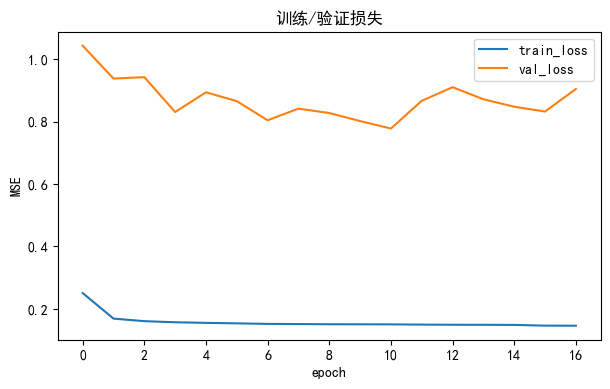

In [8]:
# ========= 9) Loss 曲线 =========
fig = plt.figure(figsize=(7,4))
plt.plot(history['train_loss'], label='train_loss')
if len(history.get('val_loss', [])) > 0 and len(history['val_loss']) > 0:
    plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.title('训练/验证损失')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

# 保存图到 results/<exp>_<timestamp>/figures/
save_figure(fig, run_dir / 'figures' / 'loss_curve.png')

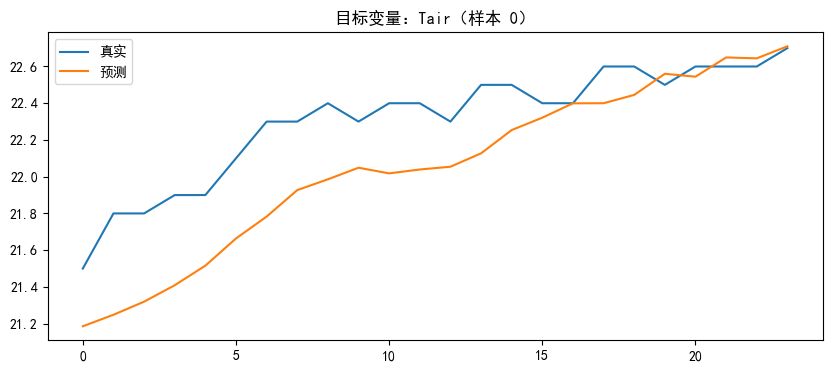

In [9]:
# ========= 10) 单样本预测可视化（反标准化） =========
model.eval()
x, y = next(iter(test_loader))
x = x.to(device)
with torch.no_grad():
    y_hat = model(x).cpu().numpy()
y_true = y.numpy()

y_hat_inv = target_scaler.inverse_transform(y_hat.reshape(-1, len(target_cols))).reshape(y_hat.shape)
y_true_inv = target_scaler.inverse_transform(y_true.reshape(-1, len(target_cols))).reshape(y_true.shape)

sample = 0
var_idx = 0
fig = plt.figure(figsize=(10,4))
plt.plot(y_true_inv[sample, :, var_idx], label='真实')
plt.plot(y_hat_inv[sample, :, var_idx], label='预测')
plt.title(f'目标变量：{target_cols[var_idx]}（样本 {sample}）')
plt.legend()
plt.show()

save_figure(fig, run_dir / 'figures' / f'pred_curve_{target_cols[var_idx]}.png')